In [87]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

np.random.seed(0)
torch.manual_seed(0)

# reber文法
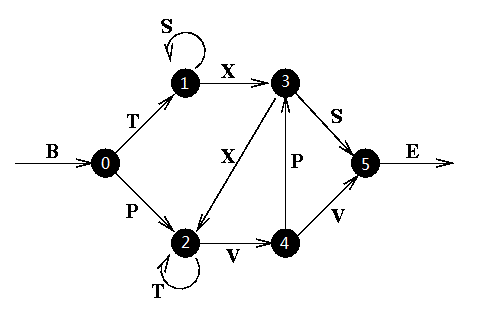

reber文法可以用来验证一个模型是否具有记忆能力。
我们可以训练一个模型来判断一个字符串是否是符合reber文法的。  
对于RNN来说，训练阶段首先在每次输入一个字符后，都给出下一个字符的监督信号。  
测试阶段，对于每一个输入字符后的输出值，判断它是否是满足reber文法的，如果全部满足，则视为成功。

In [88]:
# 生成reber语言
def REBER(n, lenth=None):
    N = 0
    R = []
    while N < n:
        r, s = "B", 0 # 初始文字，状态
        transfer_map = {
            0 : [("T", 1), ("P", 2)],
            1 : [("S", 1), ("X", 3)],
            2 : [("T", 2), ("V", 4)],
            3 : [("X", 2), ("S", 5)],
            4 : [("P", 3), ("V", 5)]
        }

        while s != 5 :
            if np.random.rand() > 0.5:
                next_state = transfer_map[s][0]
            else:
                next_state = transfer_map[s][1]
            r += next_state[0]
            s = next_state[1]

        r += "E"
        
        if lenth:
            if len(r) == lenth:
                R.append(r)
                N += 1
        else:
            R.append(r)
            N += 1
    
    return R

train_data = REBER(256, 10)
print(train_data)

['BTXXTTTVVE', 'BPVPXTVPSE', 'BPTVPXTVVE', 'BPTVPXVPSE', 'BPTVPXVPSE', 'BPTTTTVPSE', 'BTXXTTTVVE', 'BPTVPXVPSE', 'BPTTTTTVVE', 'BPTTTTTVVE', 'BTSSSSSXSE', 'BPTVPXVPSE', 'BTXXTTVPSE', 'BPTVPXTVVE', 'BPTTTTVPSE', 'BPTVPXVPSE', 'BPTTTTTVVE', 'BPTTTTVPSE', 'BPTTVPXVVE', 'BTSSSSSXSE', 'BTXXVPXVVE', 'BPTTTTVPSE', 'BPTTTTTVVE', 'BTSSXXTVVE', 'BPVPXTTVVE', 'BTSSSXXVVE', 'BPTTTTTVVE', 'BTXXTTTVVE', 'BPTVPXTVVE', 'BPVPXTTVVE', 'BPTVPXVPSE', 'BTXXTTTVVE', 'BPTVPXVPSE', 'BPTTTTTVVE', 'BPTTTTVPSE', 'BTSSSXXVVE', 'BPTVPXTVVE', 'BPTTTTVPSE', 'BPTTTTTVVE', 'BPTVPXVPSE', 'BPVPXTVPSE', 'BTSSXXTVVE', 'BTSXXTVPSE', 'BTXXVPXVVE', 'BTXXTTVPSE', 'BTSXXTTVVE', 'BTSSSXXVVE', 'BTSSSSSXSE', 'BPTTTTTVVE', 'BPVPXTTVVE', 'BTXXTTVPSE', 'BTXXTTTVVE', 'BTSSSXXVVE', 'BPTTTTVPSE', 'BTSXXTVPSE', 'BTXXVPXVVE', 'BPTTTTVPSE', 'BPTTVPXVVE', 'BTSSXXVPSE', 'BTXXTTVPSE', 'BTSSXXTVVE', 'BTSXXTTVVE', 'BPTTVPXVVE', 'BTSSSXXVVE', 'BTXXVPXVVE', 'BTXXVPXVVE', 'BPVPXTVPSE', 'BPTVPXVPSE', 'BPVPXTTVVE', 'BTSSSSSXSE', 'BTSXXTTVVE', 'BPVP

In [89]:
char_list = list("BTPSXVE")
char_num  = len(char_list)
char_map  = {c : char_list.index(c) for c in char_list}
char_map

{'B': 0, 'T': 1, 'P': 2, 'S': 3, 'X': 4, 'V': 5, 'E': 6}

In [90]:
# data  = [1, 2]
# index = [0, 1]
# data[index]

In [91]:
data  = torch.tensor([1, 2])
index = torch.tensor([1, 0])
data[index]

tensor([2, 1])

In [92]:
permutation = np.arange(7)
np.random.shuffle(permutation)
permutation.tolist()

[3, 6, 4, 2, 5, 1, 0]

In [93]:
# 数据生成器，用于读取批量数据
# 每个序列的前 L-1 位作为输入，后 L-1个作为监督信号
def data_iter(batch_size, data):
    # 数据大小
    data_num = len(data)
    seq_num  = len(data[0])
    char_num = 7
    # 随机排列
    permutation = np.arange(data_num)
    np.random.shuffle(permutation)
    permutation = permutation.tolist()
    # 每次取 batch_size 个
    for i in range(0, data_num, batch_size):
        # 每个 batch 的下标
        indices = permutation[i:i+batch_size]
        
        # 按照时间顺序变换
        batch_n_list = [] # 得到每一个字符对应的数字
        batch_n_advisor_list = [] # 监督信号
        for j in indices:
            # 对batch中下标为j的字符串数字化
            n_list = []
            for k in data[j]:
                # 获取该字符对应的数字
                n_list.append(char_map[k])
            
            batch_n_list.append(n_list[:-1])
            batch_n_advisor_list.append(n_list[1:])

        # 将其传入one_hot函数，得到(batch*seq*char)的tensor
        batch_seq_one_hot = F.one_hot(torch.tensor(batch_n_list), char_num)
        
        # 改为seq first的tensor，转置前两维
        seq_batch_one_hot = batch_seq_one_hot.transpose(0, 1)
        
        # advisor的tensor(batch*seq*char)
        batch_seq_advisor = torch.tensor(batch_n_advisor_list)
        seq_batch_advisor = batch_seq_advisor.transpose(0, 1) # 转置
        
        yield seq_batch_one_hot, seq_batch_advisor
    
data_iter_ = data_iter(5, train_data)
for _ in range(1):
    data = next(data_iter_)
    print(data)

(tensor([[[1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 1, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0],
         [0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0]],

        [[0, 0, 0, 0, 0, 1,

In [94]:
class ReberRNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # parameters
        seq_num  = 9
        char_num = 7
        
        # layers
        self.input_hidden_layer = nn.RNN(input_size=char_num, hidden_size=10, bias=False)
        self.output_layer = nn.Linear(in_features=10, out_features=char_num, bias=False)
        
    def forward(self, input):
        hidden_output, h_n = self.input_hidden_layer(input)
        output = self.output_layer(hidden_output)
        
        return output

In [104]:
myNN = ReberRNN()

# 训练阶段
epoch_num  = 20000
batch_size = 16
learning_rate = 1e-3

# 生成优化器
optimizer = optim.SGD(myNN.parameters(), lr=learning_rate)

for epoch in range(epoch_num):
    for INPUT, TARGET in data_iter(batch_size, train_data):
        # forward
        output = myNN(INPUT.float())
        Loss = F.cross_entropy(output.reshape(-1, 7), TARGET.reshape(-1))
        
        # update
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

    if epoch % 2000 == 0:
        print(" for epoch %d\t\t, Loss is %s" % (epoch, Loss.item()))

 for epoch 0		, Loss is 1.9831829071044922
 for epoch 2000		, Loss is 0.7491315007209778
 for epoch 4000		, Loss is 0.45513254404067993
 for epoch 6000		, Loss is 0.3873934745788574
 for epoch 8000		, Loss is 0.39099010825157166
 for epoch 10000		, Loss is 0.37793800234794617
 for epoch 12000		, Loss is 0.33781343698501587
 for epoch 14000		, Loss is 0.3482116758823395
 for epoch 16000		, Loss is 0.3533514738082886
 for epoch 18000		, Loss is 0.32426369190216064


In [105]:
# 预测一个序列
seq = 'BTXXTTTVVE'
# 转为 seq_one_hot
n_list = []
for i in seq:
    # 获取该字符对应的数字
    n_list.append(char_map[i])
seq_one_hot = F.one_hot(torch.tensor(n_list))
seq_one_hot = 

tensor([[1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1]])

In [109]:
test_output = myNN(seq_one_hot[:-1].unsqueeze(1).float())
test_output

tensor([[[-1.0221,  5.0124,  4.8704, -4.4831, -1.1977, -1.2870, -2.3018]],

        [[-1.6839, -0.2463, -3.3010,  4.7795,  4.2166, -0.7522, -2.8991]],

        [[-1.9538,  1.4334, -4.0466,  2.5301,  6.7014,  0.7268, -5.0841]],

        [[-1.7492,  5.5589, -0.6252, -3.6121,  1.1580,  4.7948, -6.3426]],

        [[-1.6583,  6.6383,  0.5184, -3.8122, -0.3796,  2.3790, -4.3550]],

        [[-1.9074,  5.3163, -0.7433, -3.4456, -0.1438,  4.8603, -4.3336]],

        [[-2.1524,  1.7913,  1.0183, -4.2614, -3.2933,  8.5245, -2.9003]],

        [[-0.5383, -3.2413,  0.7687, -2.1167, -6.2600,  7.8797,  1.9091]],

        [[ 0.5840, -7.1232,  1.0166,  1.0944, -2.4306, -1.9987,  7.6503]]],
       grad_fn=<UnsafeViewBackward>)